In [1]:
!pip install pybullet imageio-ffmpeg

import os
import time
import math
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pybullet as p
import pybullet_data
import cv2
import imageio_ffmpeg
from base64 import b64encode
from IPython.display import HTML

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 MB 5.7 MB/s eta 0:00:00


In [126]:
import numpy as np
import imageio_ffmpeg
import pybullet as p
import math

# Configura la simulazione e la fotocamera
p.connect(p.DIRECT)  # Usa la modalità senza GUI per evitare un impatto sulle prestazioni
p.resetSimulation() # Lui va chiamato la mattina appena apri il computer
#p.setGravity(0, 0, -9.81)
p.setTimeStep(0.01)  # Imposta il passo temporale per la simulazione

# Aggiungi il percorso dei dati PyBullet
p.setAdditionalSearchPath(pybullet_data.getDataPath())

In [3]:
!git clone https://github.com/Gaianeve/Real_Mega_Fufi.git
%cd Real_Mega_Fufi/Robot/1LegTrail/

Cloning into 'Real_Mega_Fufi'...
remote: Enumerating objects: 1364, done.
remote: Counting objects: 100% (348/348), done.
remote: Compressing objects: 100% (320/320), done.
remote: Total 1364 (delta 260), reused 27 (delta 27), pack-reused 1016 (from 3)
Receiving objects: 100% (1364/1364), 14.51 MiB | 7.74 MiB/s, done.
Resolving deltas: 100% (889/889), done.
/content/Real_Mega_Fufi/Robot/1LegTrail


In [127]:
plane_pos = [0,0,0]
plane = p.loadURDF("plane.urdf", plane_pos, useFixedBase=True)

# position of the base of the model
PIP_position = [0,0,0]
orientation  = [0,0,0]
PIP_orientation = p.getQuaternionFromEuler(orientation)
PIPPA_id = p.loadURDF("PIPPA_oneleg.urdf", basePosition = PIP_position, baseOrientation = PIP_orientation, \
                      useFixedBase=False)


In [128]:
#change colors
p.changeVisualShape(PIPPA_id, -1, rgbaColor=[1, 0.65, 0, 1]) #terreno arancione
p.changeVisualShape(PIPPA_id, 0, rgbaColor=[0.5, 1, 0.5, 1]) #colonna verdino
p.changeVisualShape(PIPPA_id, 1, rgbaColor=[0.5, 0.8, 1, 1]) #colonna azzurrino

In [129]:
link_name_to_index = {p.getBodyInfo(PIPPA_id)[0].decode('UTF-8'):-1,}

for id in range(p.getNumJoints(PIPPA_id)):
  name = p.getJointInfo(PIPPA_id, id)[12].decode('UTF-8')
  link_name_to_index[name] = id

angular_damping = 1
for link_index in range(-1, 2):
  print(link_index)
  p.changeDynamics(
    bodyUniqueId=PIPPA_id,
      linkIndex=link_index,
      angularDamping=angular_damping
  )


-1
0
1


In [130]:
#get initial position (rest)
column_pos, coloum_or = p.getBasePositionAndOrientation(PIPPA_id)
x_rest_column = column_pos[0]
y_rest_column = column_pos[1]

joint_pos, joint_or = p.getLinkState(PIPPA_id, 0)[0:2]
x_rest_joint = joint_pos[0]
y_rest_joint = joint_pos[1]

leg_pos, leg_or = p.getLinkState(PIPPA_id, 1)[0:2]
x_rest_leg = leg_pos[0]
y_rest_leg = leg_pos[1]

#esternale force due to seismic motion
force_module = np.array([0.25, 0, 0])
force_position = column_pos

#elastic force:
def spring(x_now, y_now, x_rest, y_rest):
  force_module_x = -1800*(x_now - x_rest)
  force_module_y =  -1800*(y_now - y_rest)
  return force_module_x, force_module_y

In [131]:

# Parametri della fotocamera
cam_target_pos = [0, 0, 0]
cam_distance = 2
cam_yaw, cam_pitch, cam_roll = 50, -30.0, 0
cam_width, cam_height = 480, 360
cam_up_axis_idx = 2
cam_fov = 60
cam_near_plane, cam_far_plane = 0.01, 100

# Imposta la registrazione del video
vid = imageio_ffmpeg.write_frames('simulation_output.mp4', (cam_width, cam_height), fps=30)
vid.send(None)  # Inizializza con un fotogramma vuoto
p.stepSimulation()

()

In [132]:
# Liste per registrare le posizioni
leg_positions_x, leg_positions_y, leg_position_z = [], [], []
joint_positions_x, joint_positions_y, joint_position_z = [], [], []
column_positions_x, column_positions_y, column_positions_z = [], [], []

In [133]:
# Ciclo principale della simulazione
for step in range(4000):
    #print(f'\rtimestep {step}...', end='')
    if 50 <= step < 1500:
      # Applicare la forza esterna al primo passo della simulazione
      p.applyExternalForce(
          objectUniqueId= PIPPA_id,
          linkIndex=-1,
          forceObj=force_module,
          posObj=force_position,
          flags=p.WORLD_FRAME
        )

    # Registrazione della posizione della gamba
    leg_position, leg_orientation = p.getLinkState(PIPPA_id,1)[0:2]

    #column position
    column_position, column_orientation = p.getBasePositionAndOrientation(PIPPA_id)

    #joint position
    joint_position, joint_orientation = p.getLinkState(PIPPA_id,0)[0:2]

    #apply elastic call back forces
    elastic_force_x_column, elastic_force_y_column = spring(column_position[0], \
                                                            column_position[1], \
                                                            x_rest_column, \
                                                            y_rest_column)
    elastic_force_column = [elastic_force_x_column, elastic_force_y_column,0]

    elastic_force_x_leg, elastic_force_y_leg = spring(leg_position[0], \
                                                      leg_position[1], \
                                                      x_rest_leg, \
                                                      y_rest_leg)
    elastic_force_leg = [elastic_force_x_leg, elastic_force_y_leg,0]

    elastic_force_x_joint, elastic_force_y_joint = spring(joint_position[0], \
                                                            joint_position[1], \
                                                            x_rest_joint, \
                                                            y_rest_joint )
    elastic_force_joint = [elastic_force_x_joint, elastic_force_y_joint,0]

    if 50 <= step < 2000:
      # elastic forcce on leg
      p.applyExternalForce(
          objectUniqueId= PIPPA_id,
          linkIndex=1,
          forceObj=elastic_force_leg,
          posObj=leg_position,
          flags=p.WORLD_FRAME
        )
      #elastic force on column
      p.applyExternalForce(
          objectUniqueId= PIPPA_id,
          linkIndex= -1,
          forceObj=elastic_force_column,
          posObj=column_position,
          flags=p.WORLD_FRAME
        )
      #elastic force on joint
      p.applyExternalForce(
          objectUniqueId= PIPPA_id,
          linkIndex=0,
          forceObj=elastic_force_joint,
          posObj=joint_position,
          flags=p.WORLD_FRAME
        )
    leg_position, leg_orientation = p.getLinkState(PIPPA_id,1)[0:2]
    leg_positions_x.append(leg_position[0])
    leg_positions_y.append(leg_position[1])
    leg_position_z.append(leg_position[2])

    #column position
    column_position, column_orientation = p.getBasePositionAndOrientation(PIPPA_id)
    column_positions_x.append(column_position[0])
    column_positions_y.append(column_position[1])
    column_positions_z.append(column_position[2])

    #joint position
    joint_position, joint_orientation = p.getLinkState(PIPPA_id,0)[0:2]
    joint_positions_x.append(joint_position[0])
    joint_positions_y.append(joint_position[1])
    joint_position_z.append(joint_position[2])

    # Aggiorna il video
    # Calcola la vista e la proiezione della fotocamera
    cam_view_matrix = p.computeViewMatrixFromYawPitchRoll(
        cam_target_pos, cam_distance, cam_yaw, cam_pitch, cam_roll, cam_up_axis_idx
    )
    cam_projection_matrix = p.computeProjectionMatrixFOV(
        cam_fov, cam_width / cam_height, cam_near_plane, cam_far_plane
    )

    # Cattura l'immagine
    image = p.getCameraImage(cam_width, cam_height, cam_view_matrix, cam_projection_matrix)[2][:, :, :3]

    # Scrivi il fotogramma nel video
    vid.send(np.ascontiguousarray(image))

    p.stepSimulation()  # Avanza di un passo nella simulazione

# Rilascia le risorse video
vid.close()
# Disconnessione dalla simulazione
p.disconnect()

In [134]:
# Ora visualizziamo il video registrato nel notebook
mp4 = open('simulation_output.mp4', 'rb').read()  # Leggi il file video
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()  # Convertilo in Base64

# Visualizza il video nel notebook Jupyter
HTML('<video width=480 controls><source src="%s" type="video/mp4"></video>' % data_url)

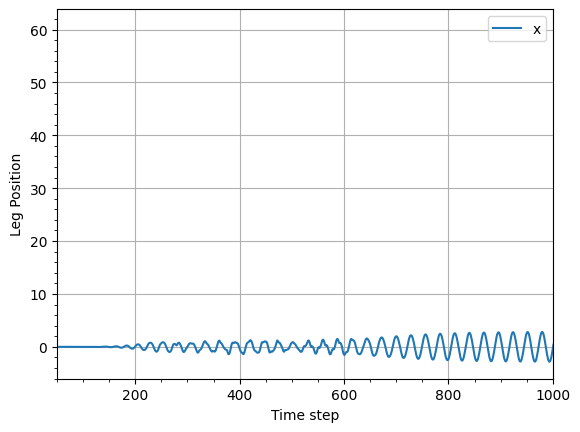

In [135]:
##plotting positions
plt.figure('Leg positions')
plt.plot(leg_positions_x, label='x')
#plt.plot(leg_positions_y, label='y')
#plt.plot(leg_position_z, label='z')
plt.xlabel('Time step')
plt.ylabel('Leg Position')
plt.legend()
plt.grid()
plt.minorticks_on()
p#lt.ylim(-10,10)
plt.xlim(50, 1000)
plt.show()

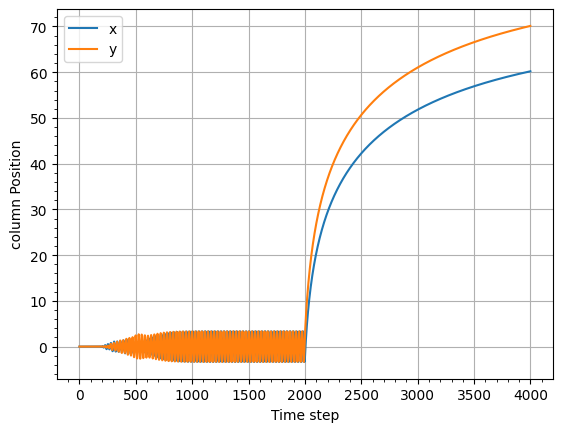

In [137]:
#plot column positions
plt.figure('column')
plt.plot(column_positions_x, label='x')
plt.plot(column_positions_y, label='y')
#plt.plot(column_positions_z, label='z')
plt.xlabel('Time step')
plt.ylabel('column Position')
plt.legend()
plt.grid()
plt.minorticks_on()
#plt.ylim(-0.05,0.0000)
#plt.xlim(50, 500)
plt.show()